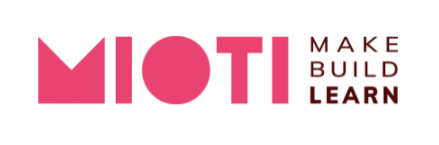

# Como usar Data Science para invertir en Bolsa

# 1. Obtención de los datos

## 1.1 Explorar la librería de Python pandas_datareader

La librería `pandas_datareader`es una de las librerías mas avanzadas para obtener datos de los mercados financieros de una forma sencilla y rápida.

Algunas de las fuentes de datos a la que nos va a dar acceso son:

* Yahoo Finance
* The Federal Reserve Bank of St Louis' FRED
* IEX
* Quandl
* Kenneth French's data library
* World Bank
* OECD
* Eurostat
* Econdb
* Nasdaq Trader symbol definitions

Si quieres analizar la lista de todas las fuentes a la que tenemos acceso gracias a esta librería visita: https://pandas-datareader.readthedocs.io/en/latest/remote_data.html

In [1]:
# Instalación de las librerías especializadas en Trade en nuestro entorno de Python
!pip install pandas-datareader cufflinks plotly pandas

In [2]:
from pandas_datareader import data
import pandas as pd # pandas impresionante libreria de análisis financiero
import mplfinance as fplt #librería gráfica para gráficos de bolsa
import cufflinks as cf
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime,timedelta

Veamos un ejemplo de como obtener la cotización histórica de Apple desde el 2010

In [5]:
start_date = '2010-01-01'
end_date = datetime.today().strftime('%Y-%m-%d') 
symbol='AAPL'
df = data.DataReader(symbol, 'yahoo', start_date, end_date)   #nos conectamos a yahoo para obtener los datos
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,7.660714,7.585000,7.622500,7.643214,493729600.0,6.553025
2010-01-05,7.699643,7.616071,7.664286,7.656429,601904800.0,6.564356
2010-01-06,7.686786,7.526786,7.656429,7.534643,552160000.0,6.459940
2010-01-07,7.571429,7.466071,7.562500,7.520714,477131200.0,6.447998
2010-01-08,7.571429,7.466429,7.510714,7.570714,447610800.0,6.490867
...,...,...,...,...,...,...
2021-11-18,158.669998,153.050003,153.710007,157.869995,137827700.0,157.869995
2021-11-19,161.020004,156.529999,157.649994,160.550003,117147500.0,160.550003
2021-11-22,165.699997,161.000000,161.679993,161.020004,117467900.0,161.020004


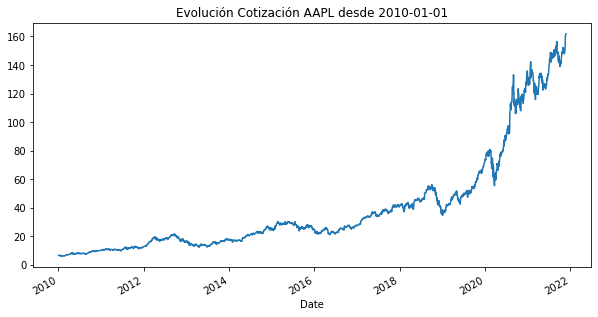

In [6]:
# Obtenemos un gráfico de cotización de la acción
plot_title='Evolución Cotización '+symbol+' desde '+ start_date
df['Adj Close'].plot(title=plot_title,figsize=(10,5));

In [7]:
qf = cf.QuantFig(df[-100:], title=plot_title, name='AAPL')
qf.iplot()

In [8]:
qf = cf.QuantFig(df[-100:], title=plot_title, name='AAPL')
qf.add_sma(periods=7, column='Close', color='red')
qf.add_sma(periods=21, column='Close', color='green')

qf.iplot()

In [9]:
qf = cf.QuantFig(df[-100:], title=plot_title, name=symbol)
qf.add_sma([10, 50], width=2, color=['blue', 'red'])
# qf.add_rsi(periods=14, color='green')
qf.add_bollinger_bands(periods=20, boll_std=2 ,colors=['orange','grey'], fill=True)
qf.add_volume()
# qf.add_macd()
qf.iplot()

Y si creamos una función que nos valga para obtener estos análisis de cualquier activo que cotice en bolsa

In [10]:
def analisis_accion(symbol='AAPL',start_date='2021-06-01',end_date=datetime.today().strftime('%Y-%m-%d'),
                    sma=False,sma_low=10,sma_high=50,sma_color=['blue','red'],
                    rsi=False,rsi_periods=14,rsi_color='green',
                    bollinger_bands=False,bb_periods=20,bb_boll_std=2,bb_colors=['orange,grey'],
                    volumen=False,
                    macd=False):
    df = data.DataReader(symbol, 'yahoo', start_date,end_date)
    plot_title='Evolución Cotización '+symbol+' '+ start_date+':'+end_date
    # print (df)
    qf = cf.QuantFig(df, title=plot_title, name=symbol)
    if sma==True:
        qf.add_sma([sma_low, sma_high], width=2, color=sma_color)
    if rsi==True:
        qf.add_rsi(periods=14, color='green')
    if bollinger_bands==True:
        qf.add_bollinger_bands(periods=20, boll_std=2 ,colors=['orange','grey'], fill=True)
    if volumen==True:    
        qf.add_volume()
    if macd==True:    
        qf.add_macd()
    qf.iplot()

In [12]:
analisis_accion(symbol='IBM')

In [13]:
analisis_accion(symbol='AAPL',sma=True,volumen=True,rsi=True,bollinger_bands=True,start_date='2021-06-01')

# Vamos a automatizar nuestro Algoritmo de Trade utilizando un Bot en Telegram

Usando la estrategia de las Bandas de Bollinger vamos a generar un Telegram Bot que nos envíe un mensaje en el mejor momento para invertir en una acción. Vamos a instalar 2 librerías de Python:

* **twx:** Libreria no oficial que nos da acceso a la API de Telegram para poder enviar mensajes desde Python a un Bot de Telegram (muy sencilla de utilizar aunque NO es oficial).

* **emoji:** Librería que nos da acceso a emojis para utilizar en nuestros mensajes

In [14]:
!pip install twx emoji

In [15]:
import plotly.io as pio
import plotly.graph_objects as go
import telegram_carlos #libreria en la que tengo mis credenciales de telegram
import requests
import json
from twx.botapi import TelegramBot, InputFileInfo, InputFile
from random import choice
from emoji import emojize

Creamos una función para enviar una imagen y un mensaje a un robot de Telegram (previamente tendremos que conocer el Token del bot que hemos creado y le chat_id del grupo donde queremos enviar el mensaje). Para conocer el Token debemos crear un Bot en Telegram utilizando BotFather, al finalizar la configuración del bot obtendremos el Token del Bot, utilizaremos ese token para el envío de los mensajes.

Para enviar los mensajes sin crear un servidor necesitamos conocer el chat_id de nuestros mensajes con el bot, para eso necesitamos enviar un mensaje ir a la página web https://api.telegram.org/bot/getUpdates e introducir el token de nuestro bot, en ese momento podremos conocer el chat_id de nuestras conversaciones con el bot.

Ver https://core.telegram.org/bots para conseguir ser un Master de Bots para Telegram.

In [16]:
def enviar_grafico_telegram(token,chat_id,bb,sma,rstd):
    # Configuración Telegram
    BOT_TOKEN = token

    s = requests.Session()

    telegram='https://api.telegram.org/bot'+str(BOT_TOKEN)+'/getUpdates'
  
    response = s.get(telegram)
    res = json.loads(response.text)
    ids = chat_id
    # Generación del Mensaje

    # Calcular la evolución de la acción del último día vs su posición en las Bandas de Bollinger
    
    evolution = round((bb['Adj Close'][-1]-sma['Adj Close'][-1])/(2*rstd['Adj Close'][-1])*100)

    today = bb['Adj Close'][-1]
    yesterday = bb['Adj Close'][-2]

    percentage_increase = 100 * (today - yesterday) / yesterday
    date = str(bb.index[-1]).split()[0]

    # En nuestro mensaje (en función de si es una señal de comprar o de venta pondremos un emoticono un otro)
    message = emojize(":date:", use_aliases=True) + ' ' + date + '\n'
    message += (percentage_increase > 0)*emojize(":up_arrow:", use_aliases=True) + (percentage_increase < 0)*emojize(":small_red_triangle_down:", use_aliases=True)
    message += '{}% | {}$\n\n'.format(round(percentage_increase,2), round(today, 2))

    if evolution > 0:
        message += '{}% Señal de *VENDER* '.format(evolution)
    else:
        message += '{}% Señal de *COMPRAR* '.format(-evolution)

    for update in res['result']:
        ids.append(update['message']['chat']['id'])

    ids = list(set(ids))

    
    bot = TelegramBot(token)
    
    for chat_id in ids:
        fp = open('fig1.png', 'rb')
        file_info = InputFileInfo('fig1.png', fp, 'image/png')
        photo = InputFile('photo', file_info)
        print(chat_id)
        bot.send_photo(chat_id=chat_id, photo=photo, caption=message)
        fp.close()
    

In [17]:
def grafico_bb(symbol='GOOGL',days=180,
                    sma=True,sma_window=20,
                    bollinger_bands=True,bb_window=20,bb_boll_std=2,
                    enviar_telegram=False):
    
    end_date = datetime.today().strftime('%Y-%m-%d')
    start_date=datetime.today()-timedelta(days=days)
    df = data.DataReader(symbol, 'yahoo', start_date, end_date)[['Adj Close']]
    ## Estrategia Bandas de Bollinger

    sma = df.rolling(window=sma_window).mean().dropna()
    rstd = df.rolling(window=bb_window).std().dropna()

    upper_band = sma + 2 * rstd
    lower_band = sma - 2 * rstd

    upper_band = upper_band.rename(columns={'Adj Close': 'upper'})
    lower_band = lower_band.rename(columns={'Adj Close': 'lower'})
    bb = df.join(upper_band).join(lower_band)
    bb = bb.dropna()

    buyers = bb[bb['Adj Close'] <= bb['lower']]
    sellers = bb[bb['Adj Close'] >= bb['upper']]
    # Vamos a dibujar el gráfico utilizando plotly

    pio.templates.default = "plotly_dark"
    plot_title='Estrategia de Bandas de Bollinger '+symbol

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=lower_band.index, 
                             y=lower_band['lower'], 
                             name='Banda Inferior', 
                             line_color='rgba(173,204,255,0.2)'
                            ))
    fig.add_trace(go.Scatter(x=upper_band.index, 
                             y=upper_band['upper'], 
                             name='Banda Superior', 
                             fill='tonexty', 
                             fillcolor='rgba(173,204,255,0.2)', 
                             line_color='rgba(173,204,255,0.2)'
                            ))
    fig.add_trace(go.Scatter(x=df.index, 
                             y=df['Adj Close'], 
                             name='Adj Close', 
                             line_color='cyan'
                            ))
    fig.add_trace(go.Scatter(x=sma.index, 
                             y=sma['Adj Close'], 
                             name='SMA', 
                             line_color='orange',
                             line_dash='dash'
                            ))
    fig.add_trace(go.Scatter(x=buyers.index, 
                             y=buyers['Adj Close'], 
                             name='Comprar', 
                             mode='markers',
                             marker=dict(
                                 color='green',
                                 size=10,
                                 )
                             ))
    fig.add_trace(go.Scatter(x=sellers.index, 
                             y=sellers['Adj Close'], 
                             name='Vender', 
                             mode='markers', 
                             marker=dict(
                                 color='red',
                                 size=10,
                                 )
                             ))
    fig.update_layout(
        title=plot_title,

        title_font_size=20,
        title_font_color="white")
    fig.show()
    fig.write_image("fig1.png")
    if enviar_telegram==True:
        # Aquí es donde tendreís que poner el token de vuestro Bot de Telegram y el chat_id donde enviaremos los mensajes
        token=telegram_carlos.token()
        chat_id=telegram_carlos.chat_id()
        enviar_grafico_telegram(token,chat_id,bb,sma,rstd)
    return


In [18]:
grafico_bb()

In [19]:
grafico_bb(symbol='IBM')

In [20]:
grafico_bb(symbol='IBM',enviar_telegram=True)

-520232613


In [21]:
grafico_bb(symbol='BTC-USD',enviar_telegram=True)

-520232613
